Notebook to perform OM optimization with the analytical Muller-Brown potential (i.e without a score-based generative model). In practice, we use the resulting transition paths as initial conditions for unbiased MD simulations. These are eventually used as training data for the generative models.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Necessary imports
from simpleMB import SimpleMB
from mb_actions import TruncatedAction, S2Action, HutchinsonAction
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import imageio
from ase import units

class Args():
    pass

args = Args()
args.device = "cuda" # or "cpu"


potential = SimpleMB(device = args.device,n_in=2)

x0, xf = potential.initial_point.cuda().detach(), potential.final_point.cuda().detach()


  0%|          | 1/500 [00:00<02:22,  3.51it/s]

Total action for the step 0 is 469.2110290527344.


 21%|██        | 106/500 [00:02<00:07, 53.06it/s]

Total action for the step 100 is 254.32623291015625.


 42%|████▏     | 209/500 [00:03<00:04, 59.57it/s]

Total action for the step 200 is 210.5449676513672.


 61%|██████▏   | 307/500 [00:05<00:03, 54.98it/s]

Total action for the step 300 is 206.7903594970703.


 81%|████████  | 406/500 [00:06<00:01, 56.67it/s]

Total action for the step 400 is 206.6111602783203.


100%|██████████| 500/500 [00:08<00:00, 62.16it/s]


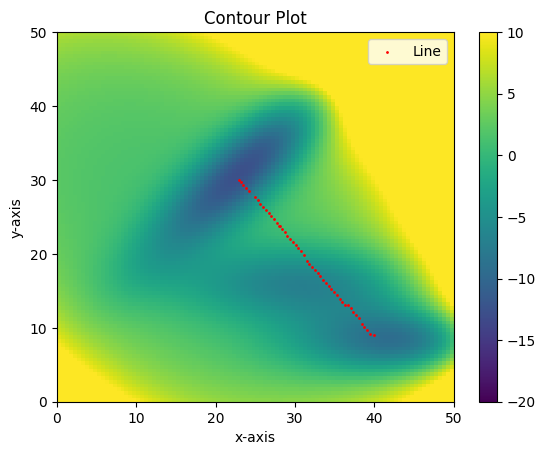

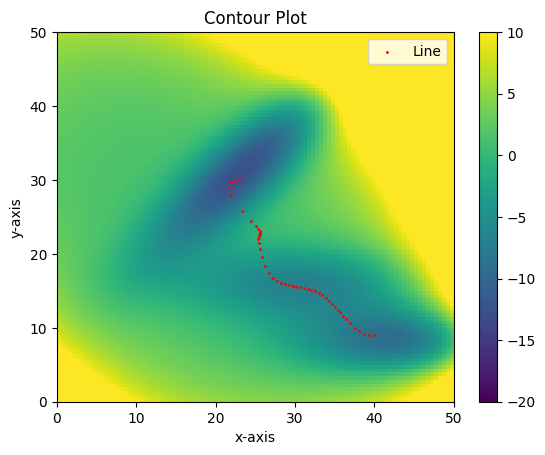

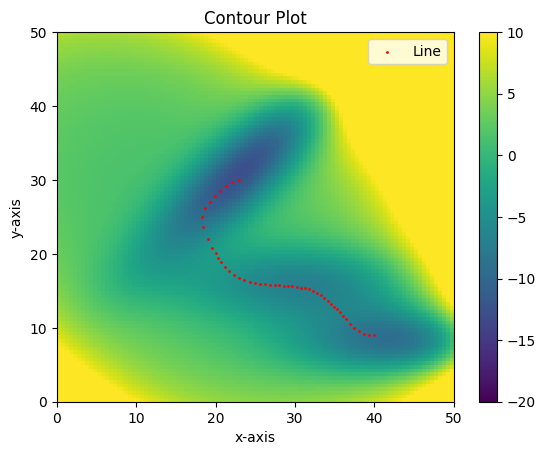

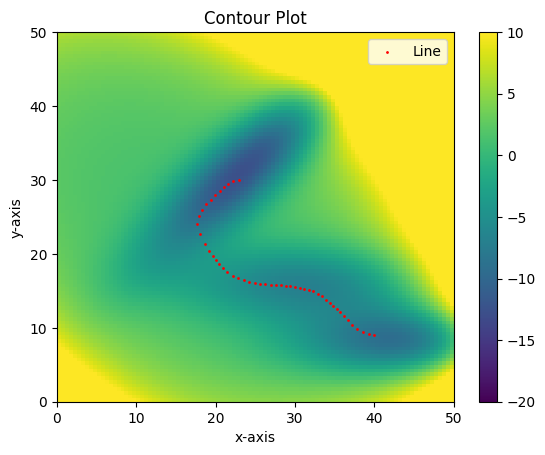

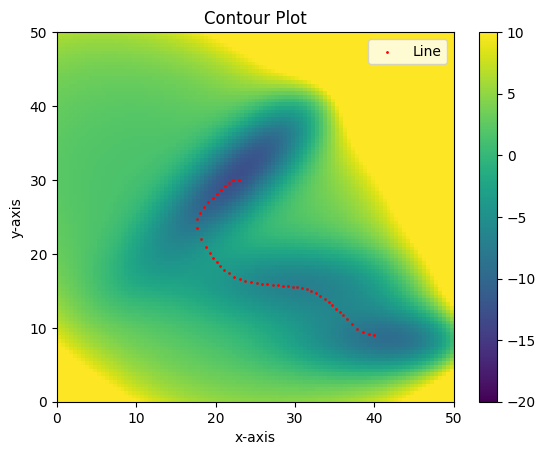

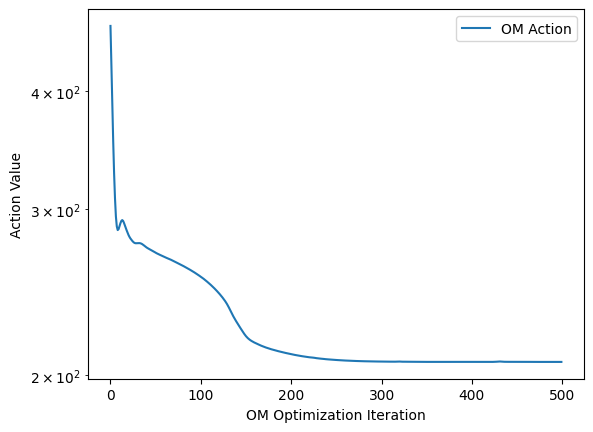

In [3]:
# Set OM Optimization Hyperparameters and Optimize

line_density = 50 # path length
dt = 0.1 # time step to use in action
gamma = torch.tensor(0.1) # gamma value to use in action
D = torch.tensor(0.2) # diffusion coefficient to use in action
action_cls = S2Action #Choose action type (TruncatedAction, S2Action, or HutchinsonAction)
force_func = lambda x: potential.force_func(x)
action_func = action_cls(force_func = force_func, laplace_func = potential.laplace, dt = dt, gamma = gamma, D = D)

iterations = 500 # number of optimization steps
alpha = 2e-1 # learning rate
write_every = 100 # how often to write to gif

line_x = torch.linspace(x0[0], xf[0],line_density)
line_y = torch.linspace(x0[1], xf[1], line_density)
line_points = torch.stack((line_x, line_y), axis=-1).to(args.device)

optimizer = torch.optim.Adam([line_points], lr = alpha)

gif_data = []

min_action = 1e9
pbar = tqdm(range(iterations))
actions = []
for i in pbar:
    line_points.requires_grad = True
    action = action_func(line_points)
    if action < min_action:
        min_action = action
        best_path = line_points.detach().cpu()
    

    total_action = action

    optimizer.zero_grad()

    grads, = torch.autograd.grad(total_action, line_points)

    
    with torch.no_grad():
        grads[0,:], grads[-1,:] = torch.zeros(2).to(args.device), torch.zeros(2).to(args.device)
        line_points.grad = grads
        optimizer.step()

        grads = grads.cpu()

    actions.append(total_action.item())
    if i % write_every == 0:
        print(f"Total action for the step {i} is {(total_action).cpu().detach().numpy()}.")
        draw_points = line_points.detach().cpu()
        num_points = 100
        x_values = torch.linspace(potential.Lx, potential.Hx , num_points)
        y_values = torch.linspace(potential.Ly, potential.Hy, num_points)

        x, y = torch.meshgrid(x_values.to(args.device), y_values.to(args.device), indexing = 'xy')
        z = potential.U_split(x, y).cpu()

        fig, ax = plt.subplots()
        colorbar = ax.imshow(z, extent=(x_values.min(), x_values.max(), y_values.min(), y_values.max()), vmin=potential.U_min, vmax=potential.U_max, origin='lower', cmap='viridis', aspect='auto')
        ax.set(xlabel="x-axis", ylabel="y-axis", title="Contour Plot")
        plt.colorbar(colorbar)

        scatter_plot = ax.scatter(draw_points[:,0], draw_points[:,1], s=1, c='red', label='Line')
        # quiver_plot = ax.quiver(draw_points[:,0], draw_points[:,1], -grads[:,0], -grads[:,1], scale_units='xy', angles='xy', color='blue', alpha=0.7)
        ax.legend()

        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype="uint8")
        image = image.reshape(
            fig.canvas.get_width_height()[::-1] + (3,)
        )
        gif_data.append(image)

if action_cls == HutchinsonAction:
    action_str = "Hutchinson"
elif action_cls == TruncatedAction:
    action_str = "Truncated"
elif action_cls == S2Action:
    action_str = "S2"
os.makedirs('results/gifs', exist_ok=True)
imageio.mimsave(f'results/gifs/analyticalMB_{action_str}_linedensity={line_density}_gamma={round(gamma.item(), 1)}_dt={round(dt, 1)}_D={round(D.item(), 1)}.gif', gif_data, fps=3)

plt.figure()
plt.plot(actions, label = "OM Action")
plt.yscale('log')
plt.xlabel("OM Optimization Iteration")
plt.ylabel("Action Value")
plt.legend()


In [ ]:
# Now, we can create a dataset using the optimized path (this is optional, since we already provide the dataset)
# CAUTION: This will overwrite the existing dataset if it exists. Change the `save_path` if you want to keep the existing dataset.
from mb_dataset import MBDataset
from mb_calculator import MullerBrownPotential
from copy import deepcopy

calculator = MullerBrownPotential(device = "cpu")
dataset = MBDataset(save_path = 'data', initial_positions= deepcopy(draw_points).numpy(), calculator=calculator, timestep = 5.0, temperature = 700, n_steps = 1000, n_sims = 10, gamma = 0.001)


489it [00:20, 23.61it/s]


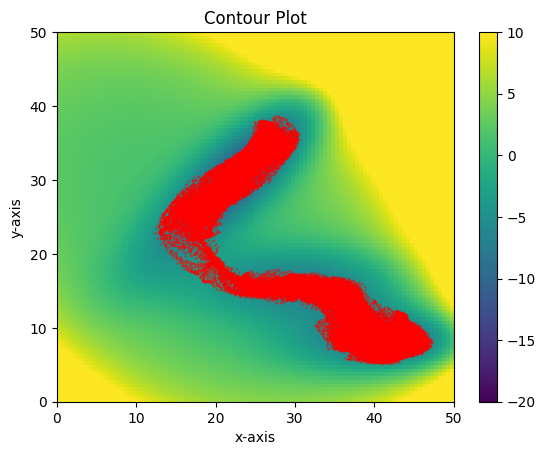

In [11]:
# visualize the dataset we just produced
from torch.utils.data import DataLoader
mb_dataloader = DataLoader(dataset, batch_size=2048, shuffle=True)

num_points = 100
x_values = torch.linspace(calculator.Lx, calculator.Hx , num_points)
y_values = torch.linspace(calculator.Ly, calculator.Hy, num_points)

x, y = torch.meshgrid(x_values, y_values, indexing="xy")
z = calculator.U_split(x, y).cpu()

fig, ax = plt.subplots()
colorbar = ax.imshow(z, extent=(x_values.min(), x_values.max(), y_values.min(), y_values.max()), vmin=calculator.U_min, vmax=calculator.U_max, origin='lower', cmap='viridis', aspect='auto')
ax.set(xlabel="x-axis", ylabel="y-axis", title="Contour Plot")
plt.colorbar(colorbar)

# also plot batch from dataloader
for i, batch in tqdm(enumerate(mb_dataloader)):
    ax.scatter(batch[:, 0], batch[:, 1], color='red', s=0.1)

# ax.scatter(draw_points[:,0], draw_points[:,1], s=1, c='blue', label='Line')
    
ax.set_xlim([calculator.Lx, calculator.Hx])
ax.set_ylim([calculator.Ly, calculator.Hy])

plt.show()
plt.close()